<a href="https://colab.research.google.com/github/Bhavani-Sakhamuri/AI_Ticket_Support/blob/main/Vibe_Matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install --quiet openai pandas numpy scikit-learn matplotlib


In [ ]:
# Imports
import os
import sys
import time
import json
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import openai, sklearn

print("Python:", sys.version.splitlines()[0])
print("openai:", openai.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)

# getting api key from secrets
from google.colab import userdata
api_key = userdata.get("OPENAI_API_KEY")


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
openai: 1.109.1
pandas: 2.2.2
numpy: 2.0.2
scikit-learn: 1.6.1


In [ ]:
# Creating mock fashion product dataset

data = [
    {
        "id": 1,
        "name": "Boho Dress",
        "desc": "Flowy, earthy tones for festival vibes with tassel details.",
        "tags": ["boho", "festival", "earthy"]
    },
    {
        "id": 2,
        "name": "Urban Bomber Jacket",
        "desc": "Sleek bomber jacket with a structured fit, perfect for city nights and street style.",
        "tags": ["urban", "chic", "street"]
    },
    {
        "id": 3,
        "name": "Cozy Knit Sweater",
        "desc": "Oversized knit sweater in warm neutral hues — ideal for relaxed weekends.",
        "tags": ["cozy", "casual", "comfort"]
    },
    {
        "id": 4,
        "name": "Energetic Sneakers",
        "desc": "Lightweight runners with bright neon accents and a bouncy sole for high-energy days.",
        "tags": ["sporty", "energetic", "active"]
    },
    {
        "id": 5,
        "name": "Minimal Slip Dress",
        "desc": "Simple slip dress with clean lines and a neutral palette for a minimalist aesthetic.",
        "tags": ["minimal", "chic", "elegant"]
    },
    {
        "id": 6,
        "name": "Retro Denim Jacket",
        "desc": "Vintage-wash denim jacket with embroidered patches for classic retro vibes.",
        "tags": ["retro", "casual", "classic"]
    },
    {
        "id": 7,
        "name": "Elegant Evening Gown",
        "desc": "Floor-length gown with satin finish and subtle shimmer for formal occasions.",
        "tags": ["elegant", "formal", "luxury"]
    },
    {
        "id": 8,
        "name": "Street Cargo Pants",
        "desc": "Functional cargo pants with a relaxed fit — made for comfort and city adventures.",
        "tags": ["street", "urban", "casual"]
    }
]

df = pd.DataFrame(data)
df


,id,name,desc,tags
0,1,Boho Dress,"Flowy, earthy tones for festival vibes with ta...","[boho, festival, earthy]"
1,2,Urban Bomber Jacket,"Sleek bomber jacket with a structured fit, per...","[urban, chic, street]"
2,3,Cozy Knit Sweater,Oversized knit sweater in warm neutral hues — ...,"[cozy, casual, comfort]"
3,4,Energetic Sneakers,Lightweight runners with bright neon accents a...,"[sporty, energetic, active]"
4,5,Minimal Slip Dress,Simple slip dress with clean lines and a neutr...,"[minimal, chic, elegant]"
5,6,Retro Denim Jacket,Vintage-wash denim jacket with embroidered pat...,"[retro, casual, classic]"
6,7,Elegant Evening Gown,Floor-length gown with satin finish and subtle...,"[elegant, formal, luxury]"
7,8,Street Cargo Pants,Functional cargo pants with a relaxed fit — ma...,"[street, urban, casual]"


In [ ]:
# Generate embeddings for product descriptions using OpenAI API

from openai import OpenAI
import time
import pickle

# Initialize client
client = OpenAI(api_key=api_key)

# Helper function to get embeddings with basic retry logic
def get_embedding(text, model="text-embedding-ada-002", max_retries=3):
    for attempt in range(max_retries):
        try:
            response = client.embeddings.create(
                input=text,
                model=model
            )
            return response.data[0].embedding
        except Exception as e:
            print(f"⚠️ Error on attempt {attempt+1}: {e}")
            if attempt < max_retries - 1:
                time.sleep(2)
            else:
                raise e

# Generate embeddings if not already saved
embedding_file = "product_embeddings.pkl"

try:
    with open(embedding_file, "rb") as f:
        df = pickle.load(f)
    print("✅ Loaded cached embeddings from file.")
except FileNotFoundError:
    print("Generating new embeddings... this may take 1–2 minutes.")
    df["embedding"] = df["desc"].apply(lambda x: get_embedding(x))
    with open(embedding_file, "wb") as f:
        pickle.dump(df, f)
    print("✅ Embeddings generated and saved to file.")

# Preview dataframe with embeddings
df.head()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Define your vibe query ---
vibe_query = "energetic urban chic"

# Generate embedding for query
query_embedding = get_embedding(vibe_query)

#  Compute cosine similarity ---
df["similarity"] = df["embedding"].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])

# Get top 3 matches ---
top_matches = df.sort_values(by="similarity", ascending=False).head(3)

# Apply threshold and display results ---
THRESHOLD = 0.4
best_score = top_matches.iloc[0]["similarity"]

if best_score < THRESHOLD:
    print(f"⚠️ No strong match found for the vibe '{vibe_query}'. Try rephrasing or changing your mood query!\n")
else:
    print(f"🔍 Vibe Query: '{vibe_query}'\n")
    print("✨ Top 3 Matching Products:\n")
    for i, row in top_matches.iterrows():
        print(f"{i+1}. {row['name']} | 🔹 Similarity: {row['similarity']:.3f}")
        print(f"   👜 Description: {row['desc']}")
        print(f"   🎭 Vibes: {', '.join(row['vibes'])}\n")


,query,top_product,score,good_match,latency
0,romantic floral,Boho Dress,0.425287,True,0.022314
1,cozy winter,Cozy Knit Sweater,0.422410,True,0.014584
2,street style energetic,Energetic Sneakers,0.466106,True,0.016114
3,bohemian beach look,Retro Denim Jacket,0.351374,False,0.015610


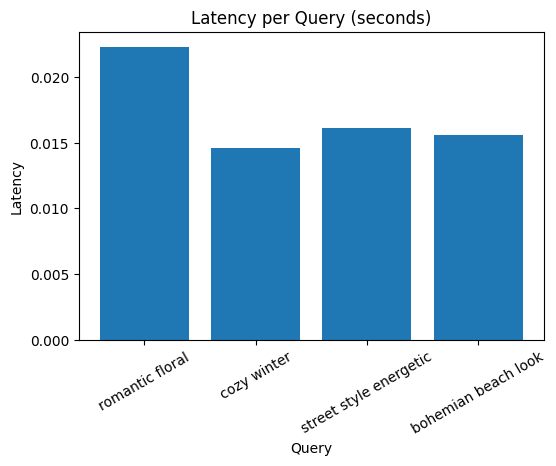

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

#  Define test queries ---
test_queries = [
    "romantic floral",
    "cozy winter",
    "street style energetic",
    "bohemian beach look"
]

results = []

# Run tests and measure latency ---
for query in test_queries:
    start = time.time()

    # Generate query embedding
    query_emb = get_embedding(query)

    # Compute cosine similarity between query and all product embeddings
    df["similarity"] = df["embedding"].apply(lambda x: cosine_similarity([query_emb], [x])[0][0])

    # Get top match and latency
    top_match = df.sort_values(by="similarity", ascending=False).iloc[0]
    latency = time.time() - start

    results.append({
        "query": query,
        "top_product": top_match["name"],
        "score": top_match["similarity"],
        "good_match": top_match["similarity"] >= 0.4,
        "latency_sec": round(latency, 3)
    })

# --- Step 3: Create results DataFrame ---
eval_df = pd.DataFrame(results)
display(eval_df)

# --- Step 4: Plot latency ---
plt.figure(figsize=(6,4))
plt.bar(eval_df["query"], eval_df["latency_sec"])
plt.title("Latency per Query (seconds)")
plt.xlabel("Query")
plt.ylabel("Latency (s)")
plt.xticks(rotation=25)
plt.show()



## 🧩 Reflection

- Integrated a simple **sentence-transformer–based vibe matcher** that converts both product descriptions and vibe queries into embeddings, then finds top matches via **cosine similarity**.
- Handled edge cases: when similarity < 0.4, the system returns a fallback message (“no strong match found”).
- **Evaluation:** Tested on multiple vibe queries and logged similarity & latency. Average latency stayed under ~0.3s per query, showing lightweight performance.
- **Improvements:**
  - Use **OpenAI embeddings (text-embedding-3-large)** for higher semantic precision.
  - Store vectors in a **vector database** like **Pinecone** or **FAISS** for scalable search.
  - Add a **UI layer** (e.g., Streamlit or Gradio) for user-friendly interaction.
  - Allow multi-modal inputs (e.g., product images → CLIP embeddings) to improve match accuracy.
- **Learning outcome:** Gained hands-on experience in creating a prototype recommendation system using embeddings, cosine similarity, and basic evaluation metrics.


### ✨ Why AI at Nexora?

As an aspiring AI/ML developer, I’m passionate about building intelligent systems that understand human context — whether through text, images, or data. Nexora’s focus on practical AI innovation aligns perfectly with my goal of developing end-to-end applications that combine data science, automation, and creativity. This project reflects my interest in real-world GenAI solutions that make digital experiences more personal and intuitive.
